### Packages

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.functions import col, lit, when
from pyspark.sql.types import *
from pyspark.sql import Row, SQLContext
from graphframes import *
sqlContext = SQLContext(sc)

from IPython.display import Image
from IPython.core.display import HTML 

from datetime import datetime
from  more_itertools import unique_everseen

import networkx as nx
import csv
import re
import requests
import numpy as np
import time
import csv
import sys
sys.setrecursionlimit(19000)

# Graph construction and modification analysis of Wikipedia pages
By Jurriaan Parie

#### Introduction
Wikipedia consists of $38$ [major categories](https://en.wikipedia.org/wiki/Category:Main_topic_classifications). Categories are used throughout Wikipedia to organize the presentation of links to articles in its various reference systems. Every category consists of pages (leaf nodes) and subcategories (non-leaf nodes). In its turn, subcategories again consists of other pages (leaf nodes) and other subcategories (non-leaf nodes). This pattern repeats itself until a subcategory only consists of leaf node (pages). This structure of categories, subcategories and pages can be represented as a graph. In this project, we aim to learn this graph structure of one major category. We do this by devising a webscraping tool that returns the pages and subcategories that are mentioned on an arbitrary Wikipedia (sub)category page. Starting at the categorical [Mathematics](https://en.wikipedia.org/wiki/Category:Mathematics) page, we use the wescraping tool to create the graph recursively using a breadth-first search. Then, we perform this recursive graph search in a parallal way using RDDs in a PySpark environment. We analyse the retrieved graph on vertex degree using Graphframes. Based on this analysis we classify Wikipedia (sub)categories as either small, medium or large. In the final part of this project, we analyse the modification activity of Wikipedia pages over 5 hours using [this](https://www.pubnub.com/developers/realtime-data-streams/wikipedia-changes/) PubNub channel. Ultimately, we combine the data from the classified subcategories and the Pubnub data to answer the main question of this project. 

#### Main question
*Are Wikipedia pages related to large sized categories modified more frequently than Wikipedia pages that are related to smaller or medium sized categories?*

#### Table of contents
1. Webscraping categorical Wikipedia pages
2. Recursive graph search
3. Parallel graph search using RDDs
4. Plotting the retrieved graph
5. Graphframe analysis
6. Wikipedia page modification analysis
7. Conclusion
8. Discussion


### 1. Webscraping categorical Wiki pages
In this first section, we devise the webscrape function ```find_edges``` that filters the html content of a categorical Wikipedia page on ```pages``` (leaf nodes) and ```subcategories``` (non-leaf nodes). The function takes 1 input variable and returns 2 output variables, which are specified in the code.

To understand the way the function works, we take a closer look at the structure of the page [```categorical Mathematics page```](https://en.wikipedia.org/wiki/Category:Mathematics). This page contains links to 25 subcategories and 20 pages. In order to retrieve those numbers, the ```find_edges``` function splits the html content of the Wiki page twice (one time to find the amount of mentioned pages and idem for subcategories). Based on those two subsets of the original html content, we filter all ```href="``` elements that correpsond to pages and subcategories. Note that since all Wiki pages adhere to the same coding structure, the strategy to split the html content to find hyperlinks for subcategories on ```CategoryTreeLabelCategory" href="``` works always. To find the hyperlinks to pages, a split on ```id="mw-pages"``` works most of the time correctly. If not, we split on ```id="catlinks"```. Note that we decidide not to collect pages that redirect to Wiki 'Portals'.

The ```find_edges``` function is defined as follows:

In [2]:
##  1.  input: 
##      - url (string): url of a Wiki category page
##  2. output: 
##      - subcat_final (list): contains all subcategory urls
##      - pages_final (list): contains all page urls

def find_edges(url):
    
    # initial lists 
    subcat_list = []   
    pages_list = []
    
    # related to webscraping
    page = requests.get(url)
    page_status = page.status_code
    page_content = page.content.decode("utf-8")
    
    ## find href subcategories
    # split content 
    subcat_split_ls = page_content.split('CategoryTreeLabelCategory" href="')
    
    # collect all remaining hrefs
    for elm in subcat_split_ls:
        if elm[0] == '/':
            subcat = elm[:elm.index('"')]
            subcat_list.append(subcat)
            
    ## find href pages
    # split content
    pages_content = page_content.split('id="mw-pages"')
    
    # exception
    if len(pages_content) == 1:
        pass
    else:
        sub_pages_content = pages_content[1][:pages_content[1].index('id="catlinks"')]

        pages_split_list = sub_pages_content.split('href="/wiki/')
        
        # collect all remaining hrefs
        for elm in pages_split_list:
            # we only allow true pages, not category pages (containing a ':' in its url)
            if (elm[0].isalpha() or elm[0].isdigit()) and ':' not in elm[0:40]:
                page = elm[:elm.index('"')]
                pages_list.append(page)
            else:
                pass
            
    # filter duplicates        
    unique_subcat_list = list(dict.fromkeys(subcat_list))
    unique_pages_list = list(dict.fromkeys(pages_list))
       
    # add wiki prefix
    subcat_final = ['https://en.wikipedia.org' + elm for elm in unique_subcat_list]
    pages_final = ['https://en.wikipedia.org/wiki/' + elm for elm in unique_pages_list]
    
    return(subcat_final, pages_final)

Note that the above code can be optimised by using the Beautifull Soup. However, at the moment of developing this code I had some difficulties with conflciting dependencies regarding this package on the GCP VM.

For the Wiki page ```Category:Mathematics```, the ```find_edges``` function returns:

In [3]:
start_url = 'https://en.wikipedia.org/wiki/Category:Mathematics'

subcat, pages = find_edges(start_url)

print("subcat:", len(subcat))
print("pages:", len(pages))

subcat: 25
pages: 19


Note that the amount of pages is 19 instead of 20 because we decided not to inlcude Wiki portals. 

Now we have created a function that returns two lists with all subcategories and pages mentioned on an arbitrary Wiki page, we are ready to devise a function that repeats this proces recursively and keeps track of all visited nodes and edges in the graph.

### 2. Recursive graph search

The function that repeats the ```find_edges``` function recursively and keeps tracks of the graph configuration is called ```graph_builder```. This function is a breadth-first search algorithm that takes 6 input variables and returns 3 output variables, which are specified in the code. Stepwise, we discuss the implementation of the algorithm.

Suppose we start with no search history, i.e. the ```vist_nodes_list```, ```edges_list``` and ```unvist_nodes_list``` are all empty lists. We activate the algorithm by adding one node to the ```unvist_nodes_list``` list and set ```node_url``` to this starting node. Before calling the ```find_edges``` function to find all pages and subcategories mentioned on this (node) Wiki page, the ```graph_builder``` function first adds the current node to the list with visted nodes and removes the node from the list with unvisited nodes. Then, the ```find_edges``` function is executed and all non-leaf nodes (subcategories) are added to ```unvist_nodes_list```. When all non-leaf nodes and leaf nodes (subcategories and pages) are merged into one list, all edges are created from the current node to all child nodes. Next, the iteration counter is increased by one and if the iteration limit (recursion depth) is not reached and the unvisited edge list is not empty, this process is repeated for the next node in the unvisited edge list. If the recursion limit is reached or the unvisited edge list is empty, the function returns 3 lists with all edges, visited and unvisited nodes.

This process is coded in the below ```graph_builder``` function:

In [4]:
##  1.  input: 
##      - node_url (string): url of a current node
##      - vist_nodes_list (list): list with all visited nodes
##      - edges_list (list): list with all edges
##      - unvist_nodes_list (list): list with all unvisited nodes
##      - it (integer): current iteration
##      - it_thres (integer): iteration threshold/recursion limit
##  2. output: 
##      - vist_nodes_list (list):
##      - edges_list (list): 
##      - unvist_nodes_list (list): 

def graph_builder(node_url, vist_nodes_list, edges_list, unvist_nodes_list, it, it_thres):
    if it % 2000 == 0:
        print(it, ":", node_url)
        print("#unvisited nodes:", len(unvist_nodes_list))
        
    if node_url not in vist_nodes_list:
    
        # add current node to visited nodes list
        vist_nodes_list.append(node_url)

        # remove current node from unvisited nodes list
        url_idx = unvist_nodes_list.index(node_url)
        del unvist_nodes_list[url_idx]
        
        # find all pages and subcategories mentioned on the url
        subcat, pages = find_edges(node_url)

        # add all new non-leaf nodes to unvist_nodes_list
        for url_subcat in subcat:
            unvist_nodes_list.append(url_subcat)
            
        # remove duplicates nodes from unvist_nodes_list 
        unvist_nodes_list = list(unique_everseen(unvist_nodes_list))

        # determine all edges from the current node
        all_edges = subcat + pages

        # add all new edges to edges_list
        for link in all_edges:
            edges_list.append((node_url,link))

        it = it + 1
        while True:
            if it == it_thres:
                return(vist_nodes_list, edges_list, unvist_nodes_list)  

            if len(unvist_nodes_list) == 0:
                return(vist_nodes_list, edges_list, unvist_nodes_list)

            else:
                new_node = unvist_nodes_list[0]
                return(graph_builder(new_node, vist_nodes_list, edges_list, unvist_nodes_list, it, it_thres)) 
                    
    else:
        it = it + 1
        # if current node is already visited
        del unvist_nodes_list[0]
        
        if len(unvist_nodes_list) != 0:
            new_url = unvist_nodes_list[0]

            if it == it_thres:
                return(vist_nodes_list, edges_list, unvist_nodes_list) 

            else:
                return(graph_builder(new_url, vist_nodes_list, edges_list, unvist_nodes_list, it, it_thres)) 
            
        else:
            return(vist_nodes_list, edges_list, unvist_nodes_list)

We run this function for 10 iterations starting from the catgeorical Mathematics page.

In [61]:
N, E, unvist_nodes_ls = graph_builder(start_url, [], [], [start_url], 0, 10)
N

['https://en.wikipedia.org/wiki/Category:Mathematics',
 'https://en.wikipedia.org/wiki/Category:Fields_of_mathematics',
 'https://en.wikipedia.org/wiki/Category:Mathematics-related_lists',
 'https://en.wikipedia.org/wiki/Category:Mathematicians',
 'https://en.wikipedia.org/wiki/Category:Mathematical_concepts',
 'https://en.wikipedia.org/wiki/Category:Cultural_depictions_of_mathematicians',
 'https://en.wikipedia.org/wiki/Category:Mathematics_and_culture',
 'https://en.wikipedia.org/wiki/Category:Mathematical_examples',
 'https://en.wikipedia.org/wiki/Category:History_of_mathematics',
 'https://en.wikipedia.org/wiki/Category:Mathematics_and_art']

By visiting those 10 Wiki pages, already 603 edges are created and 122 nodes remain to be visited.

In [62]:
print("number of unvisited nodes:", len(unvist_nodes_ls))
print("number of created edges:", len(E))

number of unvisited nodes: 122
number of created edges: 603


To gain a better understanding of the network structure, we plot the above retrieved results.

#### 2.1 Plotting the retrieved graph (intro)
We plot the above graph of $10$ iterations using NetworkX.

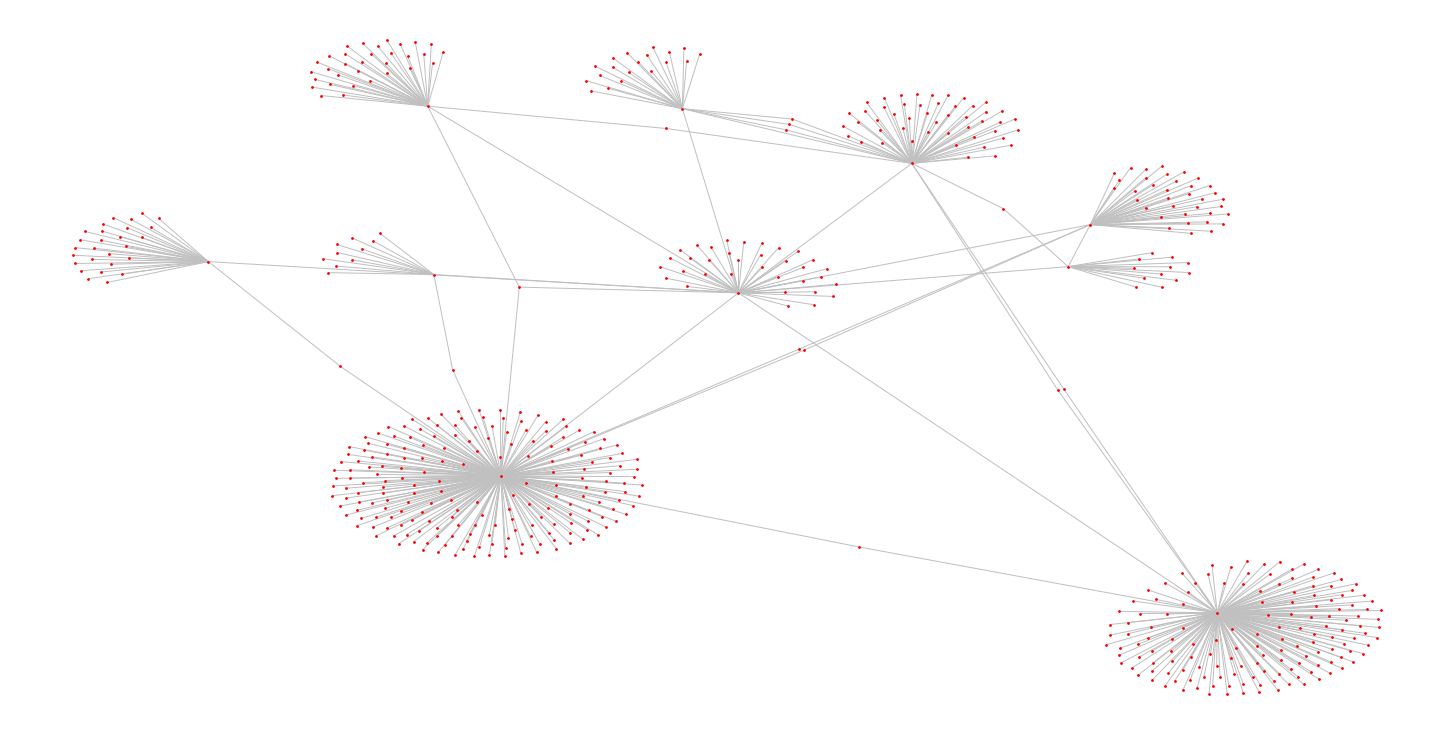

In [14]:
plt.figure(figsize=(20,10))

# initialize graph, add nodes and edges
G = nx.Graph()
G.add_nodes_from(N)
G.add_edges_from(E)

# compute graph layout
pos = nx.spring_layout(G)  

# draw nodes and edges
nx.draw(G, pos, node_size=3, node_color = 'r', edge_color='#c0c0c0') 
plt.show()

In this plot, the difference between pages (leaf nodes) and subcategories (non-leaf nodes) becomes easily visible. However, the plot has some limitation: we cannot observe the root node straight-away and the hierarchy of the tree structure is lost. In order to make this better visible, we change the way we create the graph in NetworkX. For this reason, we first create a list that contains all nodes in the graph.

In [8]:
all_nodes = []

for elm in E:
    node1 = elm[0]
    node2 = elm[1]
    all_nodes.append(node1)
    all_nodes.append(node2)
    
all_unique_nodes = list(unique_everseen(all_nodes))

Now, we add all nodes to the new directed graph ```G``` and since the edges are stored in order of visit, we iterate through the list with edges ```E``` to add all edges one at a time. In addition, if one of the nodes is one of the 10 nodes we visited, its categorical suffix is added to the dictionary labels and we plot those labels in the reuslting graph/tree.

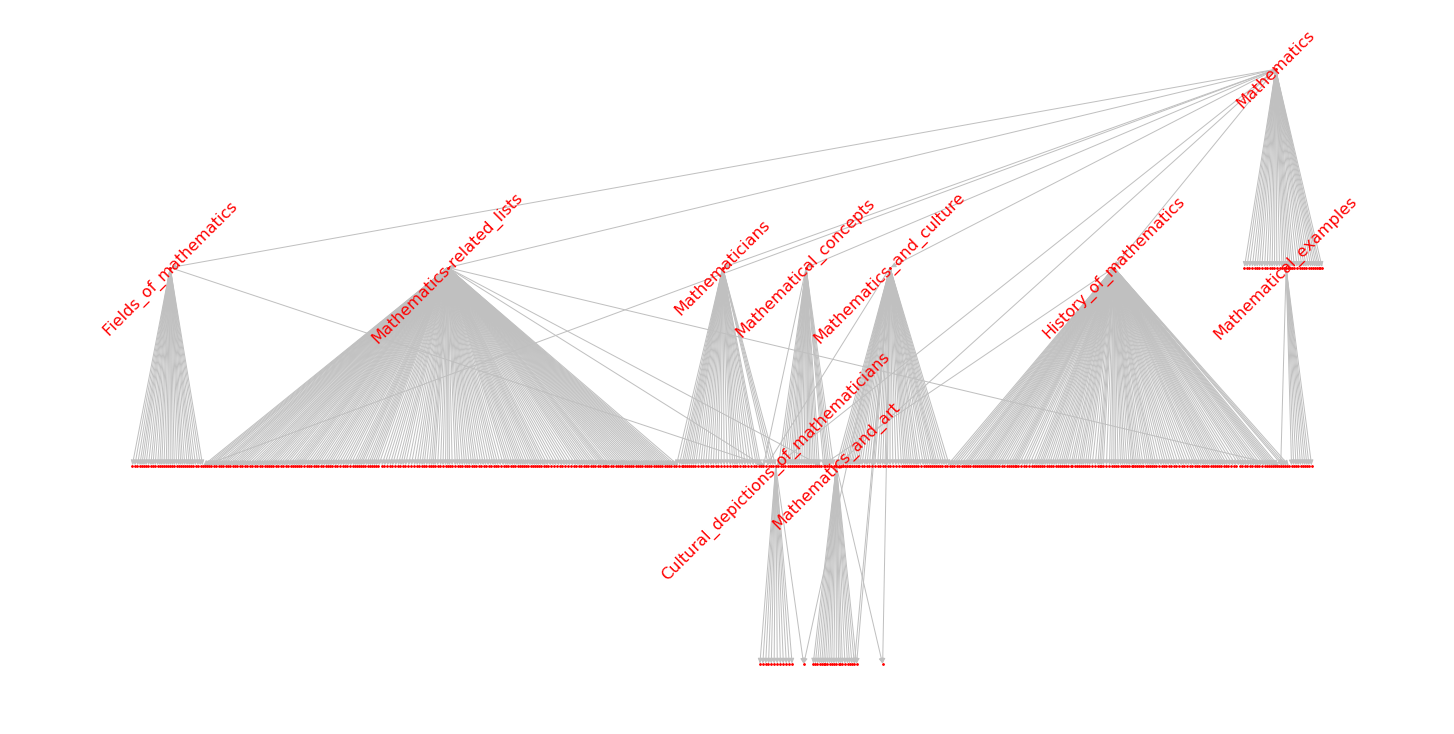

In [9]:
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

# figure dimensions
plt.figure(figsize=(20,10))

# initialize directed graph
G = nx.DiGraph()

# add all nodes to the graph
for i in range(len(all_unique_nodes)):
    G.add_node(all_unique_nodes[i])

# add all edges to the graph
for i in range(len(E)):
    G.add_edge(E[i][0], E[i][1])

# if node is visited add its categorical suffix
labels = {}    
for node in G.nodes():
    if node in N:
        #set the node name as the key and the label as its value 
        suffix = node.split('/')
        category = suffix[4].split(':')
        labels[node] = category[1]


# write dot file to use with graphviz
write_dot(G,'test.dot')

# same layout using matplotlib with no labels
pos = graphviz_layout(G, prog='dot')

# plot graph
nx.draw(G, pos, node_size=3, node_color = 'r', edge_color='#c0c0c0', with_labels=False, arrows=True)

# plot labels
plot_labels = nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='r')

# rotate labels
for _,t in plot_labels.items():
    t.set_rotation(45)

# show graph
plt.show()

The result looks nice! The hierarchical tree structure of the graph becomes better visible. Thanks to the printed labels, we gain more insight in the structure of the graph; as we consider the root node to be at level 0, we only see 7 nodes at level 1 and 2 nodes at level 2. Why is this the case? If we take a closer look at the graph, we see that all 7 the nodes at level 1 only have one incoming edge. We see that the node below between ```Cultural_depictions_of_mathematicians``` and ```Mathematics_and_art``` has multiple incoming edges. As such, the nodes with striclty more than $1$ incoming node are placed on level 2. This implies that the graph is directed but not acyclic. Bearing this in mind, we increase the recursion depth of the graph search.

#### 2.2 Increasing the recursion depth
In this section, we scale up the extent of the graph search by increasing the recursion depth. 

The most straight-forward way of scaling up the graph search is to feed the root node ```Category:Mathematics``` to the ```graph_build``` function and wait until all nodes added to the ```unvisit_nodes_list``` are all visited by the algorithm. Since we start the search in the Category Mathematics, it could be reasonable to assume that the graph builder only searches through a (small) mathematical related subset of the roughly 5.8 million English Wikipedia pages. However, the following example illustrates that this assumption is rather naive.

The Wikipedia category ```Mathematics``` redirects (->) in 5 edges to the subcategories:

```Fields_of_Mathematics``` -> ```Game_Theory``` -> ```Strategy``` -> ```Defense``` -> ```Military```.

Therefore, starting at the page ```Category:Mathematics``` does not imply that the graph search is limited to mathematical Wikipedia pages. So, if we do not set a limit on the extent of the graph search, the recursive algorithm will search through (almost) the whole Wikipedia graph (containing 5.8 million nodes and $>10^8$ edges). Hence, the default maximum recurision depth in Python (10.000 iterations) is easily exceeded. 

Nevertheless, we change the maximum recursion depth to 19.000 iterations and perform a graph search up to 18.000 iterations (to include a safety margin).

In [5]:
start_time = time.time()
nodes, edges, unvisited_nodes = graph_builder(start_url, [], [], [start_url], 0, 18000)
end_time = time.time()

print(round(end_time - start_time),'sec')

0 : https://en.wikipedia.org/wiki/Category:Mathematics
#unvisited nodes: 1
2000 : https://en.wikipedia.org/wiki/Category:New_Zealand_logicians
#unvisited nodes: 2243
4000 : https://en.wikipedia.org/wiki/Category:Rubik%27s_Cube
#unvisited nodes: 3852
6000 : https://en.wikipedia.org/wiki/Category:Massively_parallel_computers
#unvisited nodes: 6226
8000 : https://en.wikipedia.org/wiki/Category:Australian_computer_specialists
#unvisited nodes: 10057
10000 : https://en.wikipedia.org/wiki/Category:Software_engineering_publications
#unvisited nodes: 13864
12000 : https://en.wikipedia.org/wiki/Category:Athletics_(track_and_field)_competition_records
#unvisited nodes: 25745
14000 : https://en.wikipedia.org/wiki/Category:Symbolist_artists
#unvisited nodes: 30273
16000 : https://en.wikipedia.org/wiki/Category:2009_North_Indian_Ocean_cyclone_season
#unvisited nodes: 34063
998 sec


The above graph search (executed on a standard GCP virtual machine with 2 workers) takes 998 seconds to go through 18.000 iterations. Note that the number of unvisited nodes increases monotonically and that, for example, the 12.000th visited Wiki page ```(Athletics_(track_and_field)_competition_records)``` is not related to mathematics at all. 

Besides, the fact that 18.000 iterations were performered does not imply that the algorithm has visited 18.000 unique Wiki pages (nodes). Since the ```graph_builder``` function increases the iteration counter with one when a node is visited that is visited before, the amount of unique visited nodes is strictly less than 18.000. Namely, the total amount of uniquely visited nodes is:

In [6]:
print("nodes:", len(nodes))
print("edges:", len(edges))

nodes: 16398
edges: 503894


We conclude that in 18.000 iteration the graph search found 16.398 unique nodes and 503.894 edges. These nodes and edges were found in 998 seconds, that is: 16.43 nodes/second. What happens with the time consumption if we execute a parallel graph search using RDDs?

### 3. Parallel graph search using RDDs

In order to execute a parallel graph search, we parallelize the 25 subcategories of the root node ```Category:Mathematics``` in a RDD pipeline and execute the ```graph_builder``` function on each of these subcategories. In order to make a comparison with the unparallel graph search, we limit each branch to a recursion depth of 720 since then $720*25 = 18.000$ iterations will be performed.

In [8]:
rdd_urls = sc.parallelize(subcat)

# parallel graph search
start_time1 = time.time()
tree = rdd_urls.map(lambda url: graph_builder(url, [], [], [url], it = 0, it_thres = 720)).collect()
end_time1 = time.time()

print(round(end_time1 - start_time1),'sec')

288 sec


This parallel graph search (executed on a standard GCP virtual machine with 2 workers) consists of 18.000 iterations and is performed in 288 seconds. At first sight, this is much faster than the unparallel graph search. However, the 25 parallel graph searches did not communicate (shared visited nodes) with eachother during the search process. Therefore, most likely some nodes are visited multiple times in different parallel search branches. In order to check how many unique nodes the parallel graph search has visited, we first merge all visited nodes into one list.

In [9]:
all_visit_nodes_ls = []

for elm in tree:
    all_visit_nodes_ls += elm[0]

all_visit_nodes_ls_unique = list(unique_everseen(all_visit_nodes_ls))

We check how many times the iteration counter is increased by one due to a new visited node instead of a revisited node. 

In [12]:
len(all_visit_nodes_ls)

6651

Only 6.651 nodes are visited during 18.000 iterations. That is not effective at all! Now we filter on uniquely visited nodes on all 25 parallel search branches:

In [10]:
print(len(all_visit_nodes_ls_unique), "unique nodes are visited in", round(end_time1 - start_time1),'seconds.')

3911 unique nodes are visited in 288 seconds.


We conclude that a parallel graph search without parameter sharing finds 13.58 unique nodes/second. Hence, a parallel graph search without parameter sharing is very inefficient and in the end even less effective than an unparallel graph search. Besides, the hierarchy of the graph (order of appereance) became largely irreducible since now 25 different lists exists with created edges. 

Unfortunately, we do not have enough time to extend the scope of this project to include implementations for parameter sharing to perform parallel graph searches. In the next section, we visualize the graph found by the unparallel graph search.

### 4. Plotting the retrieved graph
We aim to plot the above 16.379 unique nodes and 503.484 edges we retrieved from the unparallel graph search. So let's first find all existing nodes (subcategories + pages) in the network and store them in one list.

In [7]:
all_nodes_full = []

for elm in edges:
    node1 = elm[0]
    node2 = elm[1]
    all_nodes_full.append(node1)
    all_nodes_full.append(node2)
    
all_unique_nodes_full = list(unique_everseen(all_nodes_full))

We see that the found graph consists of:

In [8]:
print(len(all_unique_nodes_full), "unique nodes in the graph.")

341023 unique nodes in the graph.


Since the graph will be quite large, the Jupyter Notebook on the GCP virtual machine is not capable to plot the graph using NetworkX due to 'insufficient memory'. Therefore, we first add all nodes and edges to the graph ```G``` but save the graph first as a ```.dot``` file using the ```graphviz``` package.

In [16]:
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

# initialize directed graph
G = nx.DiGraph()

# add all nodes to the graph
for i in range(len(all_unique_nodes_full)):
    G.add_node(all_unique_nodes_full[i])

# add all edges to the graph
for i in range(len(edges)):
    G.add_edge(edges[i][0], edges[i][1])

# write dot file to use with graphviz
write_dot(G,'full_graph.dot')

Now, we convert the ```.dot``` file to a ```.png``` image on the command line using again the package ```graphviz```. Note that we use ```-Nfontsize=0``` to hide the names of labels in the plot. 

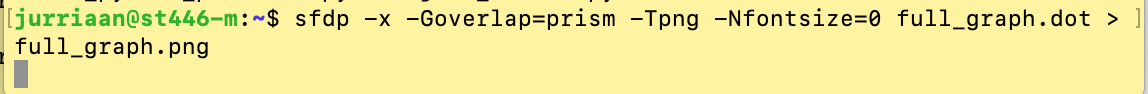

In [39]:
Image(filename = "convert_dot_png.png")

The result is shown below.

(We reduced the size and resoultion of the image to display the graph in this Notebook.)

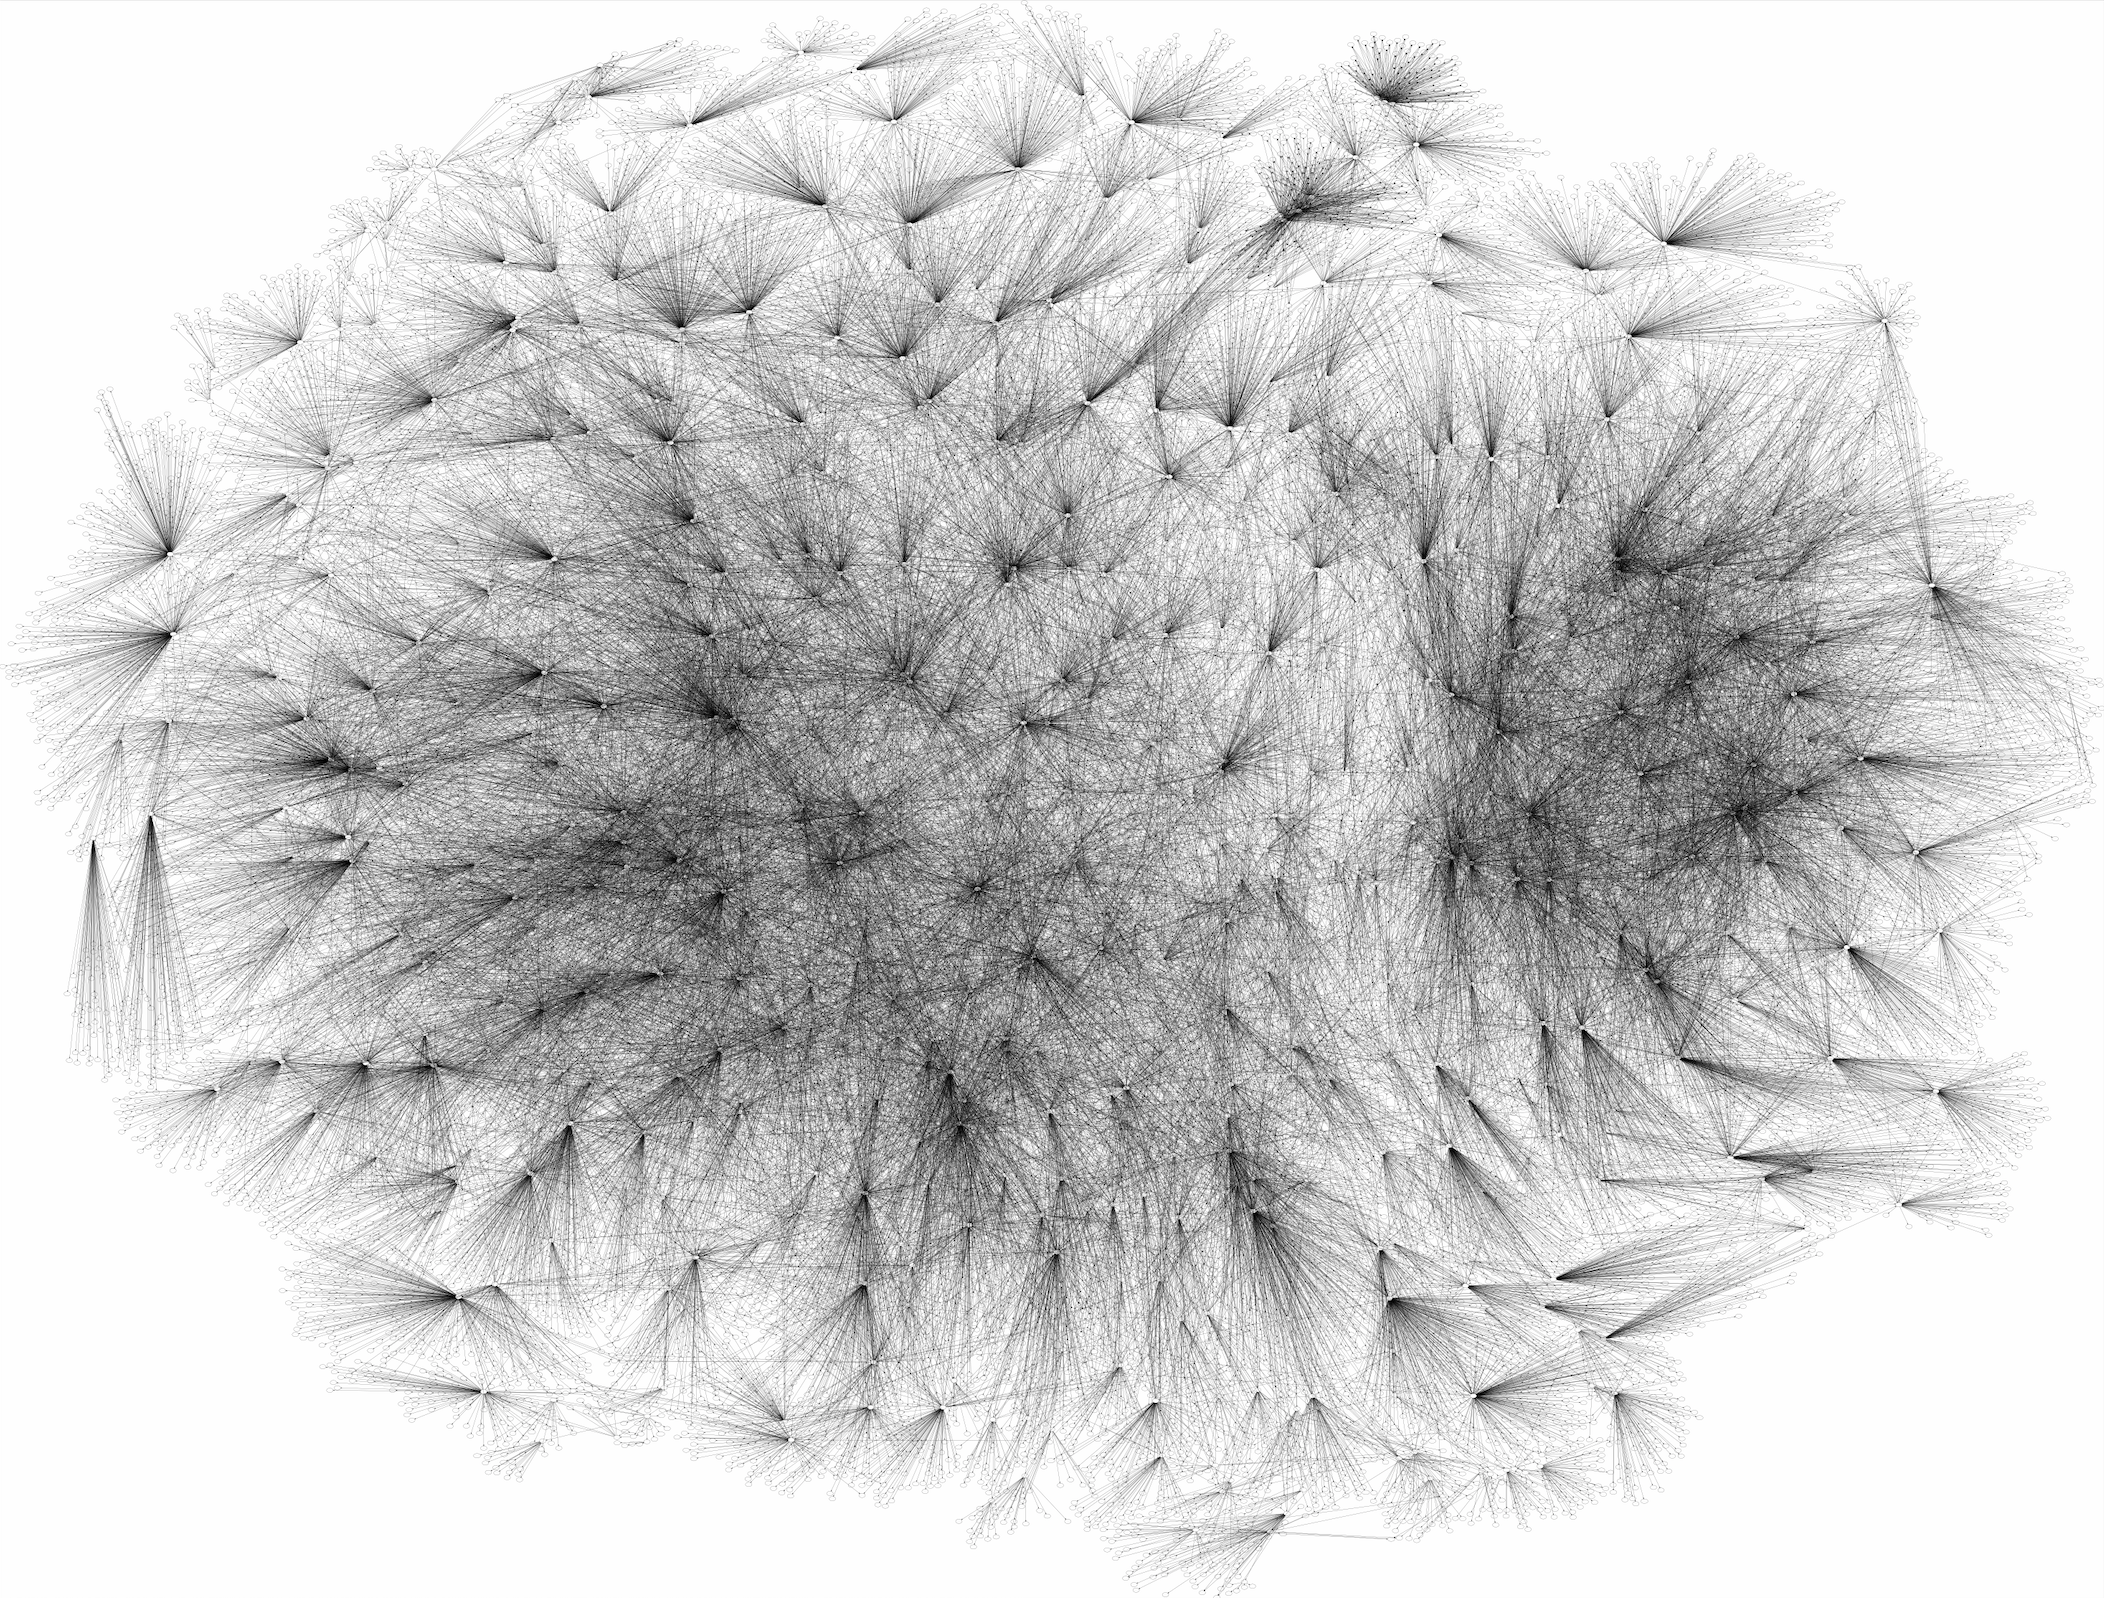

In [7]:
Image(filename = "full_graph_low_dim.png")

The graph has lost its hierarchical structure due to the occurence of cycles. We analyze characteristics of this directed cyclic graph in the next section. 

### 5. Graphframe analysis

Using the nodes and edges we found in section 4, we can analyse the above displayed graph using Graphframes. As we did in week 5's class and in Assignment 2, we first convert the nodes and edges to a Spark dataframe.    

In [8]:
node_df = spark.createDataFrame(all_unique_nodes_full, StringType()).toDF("node")
edges_df = spark.createDataFrame(edges).toDF("src","dst")

Based on these dataframes, we create a GraphFrame.

In [9]:
nodes_frame = node_df.withColumnRenamed("node","id").select("id")
edges_frame = edges_df.select("src","dst")
graph = GraphFrame(nodes_frame, edges_frame)

We can now easily find characteristics of the graph. For example, we can gain some understanding about the incoming and outcoming edges of Wikipedia subcategories and pages.

#### 5.1 Out-degrees in the Wikipedia graph

By out-degree we mean the number of edges directing from a specific node. Note that in our graph structure only subcategory pages have outgoing edges since pages are solely leaf nodes. The top 10 of Wikipedia subcategories with the highest number of out-degrees is:

In [10]:
outDegree = graph.outDegrees.sort("outDegree", ascending=False)
outDegree.collect()[0:10]

[Row(id='https://en.wikipedia.org/wiki/Category:Language_families', outDegree=399),
 Row(id='https://en.wikipedia.org/wiki/Category:Telecommunications_by_country', outDegree=364),
 Row(id='https://en.wikipedia.org/wiki/Category:Art_genres', outDegree=277),
 Row(id='https://en.wikipedia.org/wiki/Category:Functional_groups', outDegree=266),
 Row(id='https://en.wikipedia.org/wiki/Category:Art_movements', outDegree=264),
 Row(id='https://en.wikipedia.org/wiki/Category:Ethnic_groups_in_India', outDegree=254),
 Row(id='https://en.wikipedia.org/wiki/Category:Deception', outDegree=250),
 Row(id='https://en.wikipedia.org/wiki/Category:Noble_titles', outDegree=248),
 Row(id='https://en.wikipedia.org/wiki/Category:Design', outDegree=247),
 Row(id='https://en.wikipedia.org/wiki/Category:Pseudoscience', outDegree=245)]

At closer inspection we learn that a maximum of 200 pages and 200 subcategories is allowed to be mentioned on a single categorical Wikipedia page. In total, the categorical Wiki page with the highest amount of outgoing degrees, ```https://en.wikipedia.org/wiki/Category:Language_families```, has $471$ outgoing edges. However, the remaining 71 pages are showed on 'a next page' (a different html page). Note that the ```Languag_families``` category page has ```outDegree=399 since``` ```Template:Language families``` is omitted.

The distribution of out-degrees of all categorical Wikipedia pages in the graph looks like:

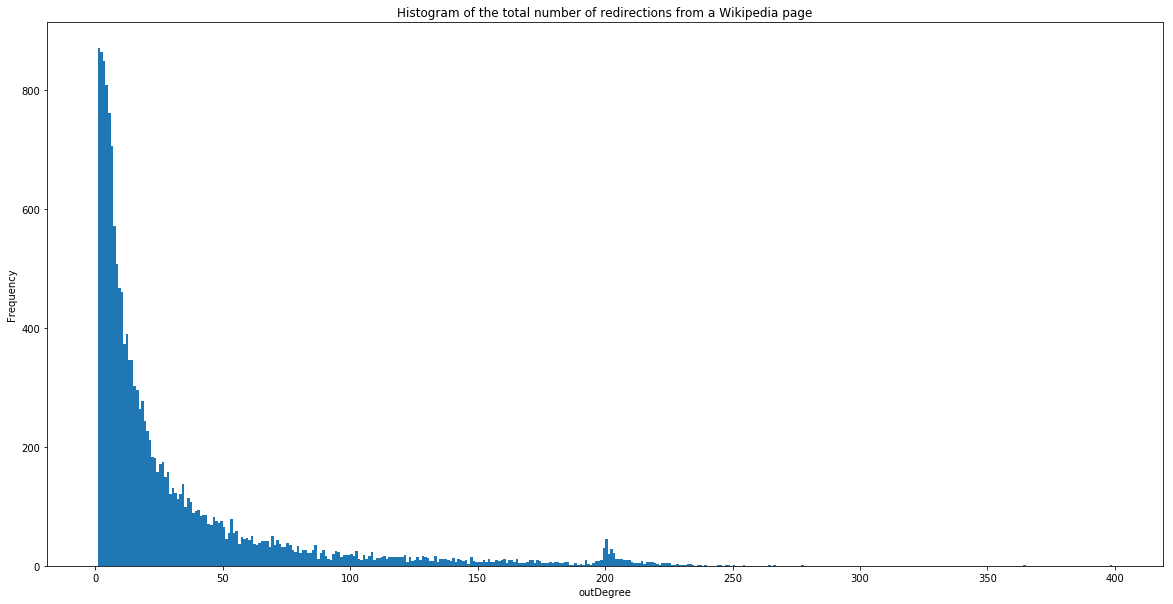

In [11]:
plt.figure(figsize=(20,10))
(n, bins, patches) = plt.hist(graph.outDegrees.select("outDegree").rdd.flatMap(lambda x: x).collect(), bins=range(1,400));
plt.ylabel('Frequency')
plt.xlabel('outDegree');
plt.title('Histogram of the total number of redirections from a Wikipedia page')
plt.show()

In total, we reviewed 16.308 nodes on their outdegree.

In [13]:
out_degree_ls = outDegree.collect()
len(out_degree_ls)

16308

Which almost equals all 16.398 nodes (subcategories) the recursive ```graph_builder``` function visited. So, apparently 92 subcategories exist but do not redirect to any subcategory or page. 

We stored the amount of subcategories in every bin of the above histogram.

In [14]:
n

array([871., 865., 849., 809., 761., 707., 571., 508., 467., 460., 373.,
       390., 346., 346., 302., 296., 264., 277., 244., 226., 211., 183.,
       181., 157., 172., 175., 150., 158., 120., 131., 122., 112., 121.,
       137.,  99., 114., 108.,  89.,  93.,  94.,  84.,  85.,  85.,  70.,
        68.,  82.,  76.,  72.,  76.,  66.,  45.,  55.,  78.,  56.,  59.,
        36.,  49.,  45.,  47.,  44.,  50.,  36.,  35.,  39.,  42.,  42.,
        41.,  31.,  50.,  35.,  43.,  36.,  32.,  31.,  38.,  35.,  26.,
        24.,  34.,  21.,  26.,  26.,  22.,  22.,  27.,  35.,  12.,  21.,
        27.,  16.,  11.,  10.,  20.,  25.,  23.,  15.,  18.,  19.,  19.,
        20.,  16.,  25.,  12.,   9.,  19.,  12.,  16.,  23.,   9.,  13.,
        13.,  15.,  16.,  11.,  15.,  14.,  15.,  14.,  15.,  14.,  19.,
         7.,  14.,   8.,  10.,  15.,  10.,  16.,  15.,  13.,   8.,   8.,
        16.,   7.,  12.,  11.,  11.,   9.,   8.,  13.,   6.,  12.,  10.,
         8.,  10.,   3.,  15.,   8.,   7.,   7.,   

In [15]:
len(n)

398

Based on this distribution we want to classify the 398 bins into three categories: *small*, *medium* or *large* amount of outdegrees. If we aim to have an equal amount of degrees in every category, we want to have up to 5.435 outdegrees in every category. We cumulative sum through the first bins to see when the limit of 5.435 is exceeded.

In [16]:
lim_counter = np.floor(16306/3)
counter = 0
l_n = len(n)

for i in range(0,l_n):
    print(counter)
    if counter < lim_counter:
        n_subcat = n[i]
        counter += n_subcat
    else:
        break

print(i)

0
871.0
1736.0
2585.0
3394.0
4155.0
4862.0
5433.0
5941.0
8


So, we classify bin 1 to 7 (subcategories with outdegree 1 to 7) as *small*.

We do the same for the category *large*. We sum from the highest bins downwards to see at what bin the limit of 5.435 is reached.

In [17]:
lim_counter = np.floor(16306/3)
counter = 0
l_n = len(n)
n_rev_range = [i for i in range(0,l_n)][::-1]

for i in n_rev_range:
    if counter < lim_counter:
        n_subcat = n[i]
        counter += n_subcat
    else:
        break

print(i)

24


Hence, we classify bin 8 to 24 as *medium* and bin 25 to 398 as *large*. We visualize this in the histogram.

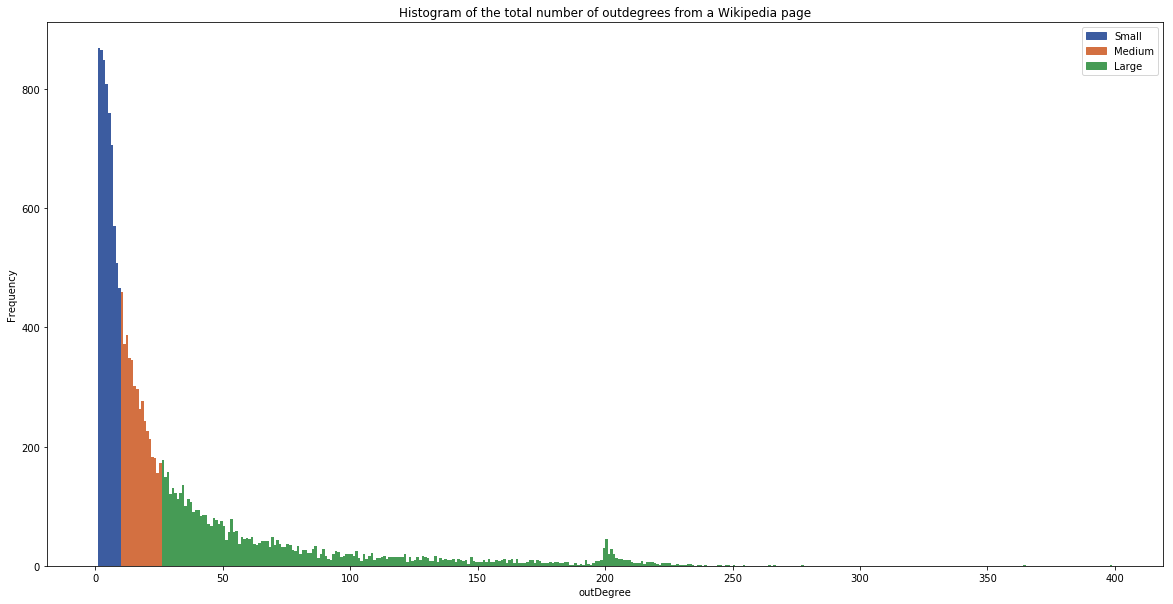

In [96]:
import matplotlib.patches as mpatches
plt.figure(figsize=(20,10))

# histogram
(n, bins, patches) = plt.hist(graph.outDegrees.select("outDegree").rdd.flatMap(lambda x: x).collect(), bins=range(1,400));

# color
for i in range(0,9):
    patches[i].set_fc("#3C5CA0")
for j in range(9,25):
    patches[j].set_fc("#D37041")
for k in range(25,398):
    patches[k].set_fc("#469B55")
    
# legend
blue_patch = mpatches.Patch(color='#3C5CA0', label='Small')
orange_patch = mpatches.Patch(color='#D37041', label='Medium')
green_path = mpatches.Patch(color='#469B55', label='Large')
plt.legend(handles=[blue_patch,orange_patch,green_path])

# plot specifications
plt.ylabel('Frequency')
plt.xlabel('outDegree');
plt.title('Histogram of the total number of outdegrees from a Wikipedia page')
plt.show()

For each subcategory url, we add its outdegree and its classification to a dictionary as a key value.

In [18]:
url_dict = {}

for elm in out_degree_ls:
    url = elm['id']
    
    # outdegree key
    out_degree = elm['outDegree'] 
    
    # class key
    if 1 <= out_degree <= 7:
        url_dict[str(url)] = (out_degree, 'small')
    elif 8 <= out_degree <= 24:
        url_dict[str(url)] = (out_degree, 'medium')
    else:
        url_dict[str(url)] = (out_degree, 'large')

The first 10 element of this dictionary look like:

In [29]:
for x in list(url_dict)[0:10]:
    print ("{}:, {} ".format(x,  url_dict[x]))

https://en.wikipedia.org/wiki/Category:Language_families:, (399, 'large') 
https://en.wikipedia.org/wiki/Category:Telecommunications_by_country:, (364, 'large') 
https://en.wikipedia.org/wiki/Category:Art_genres:, (277, 'large') 
https://en.wikipedia.org/wiki/Category:Functional_groups:, (266, 'large') 
https://en.wikipedia.org/wiki/Category:Art_movements:, (264, 'large') 
https://en.wikipedia.org/wiki/Category:Ethnic_groups_in_India:, (254, 'large') 
https://en.wikipedia.org/wiki/Category:Deception:, (250, 'large') 
https://en.wikipedia.org/wiki/Category:Noble_titles:, (248, 'large') 
https://en.wikipedia.org/wiki/Category:Design:, (247, 'large') 
https://en.wikipedia.org/wiki/Category:Pseudoscience:, (245, 'large') 


We will use those categorization later on in this project to answer the research question.

First, we give some quick insights about the indegrees of the nodes in the graph.

#### 5.2 In-degrees in the Wikipedia graph

We do the same for the top 10 of nodes with the highest number of in-degrees. With in-degree we mean: the number of incoming edges of a node. Note that these node could be both pages and subcategories.

In [10]:
inDegree = graph.inDegrees.sort("inDegree", ascending=False)
inDegree.collect()[0:10]

[Row(id='https://en.wikipedia.org/wiki/Principle', inDegree=32),
 Row(id='https://en.wikipedia.org/wiki/Wolfram_Language', inDegree=30),
 Row(id='https://en.wikipedia.org/wiki/Wolfram_Mathematica', inDegree=28),
 Row(id='https://en.wikipedia.org/wiki/Maple_(software)', inDegree=25),
 Row(id='https://en.wikipedia.org/wiki/Rationality', inDegree=24),
 Row(id='https://en.wikipedia.org/wiki/MATLAB', inDegree=23),
 Row(id='https://en.wikipedia.org/wiki/Theory_of_forms', inDegree=23),
 Row(id='https://en.wikipedia.org/wiki/Intuition', inDegree=21),
 Row(id='https://en.wikipedia.org/wiki/Freethought', inDegree=21),
 Row(id='https://en.wikipedia.org/wiki/Gottfried_Wilhelm_Leibniz', inDegree=21)]

First of all, we note that the top 10 consist merely of Wikipedia pages and no subcategories. Besides, we see that the number of incoming edges is far less than the number of outgoing edges we saw in 5.1. The distribution over all nodes looks like:

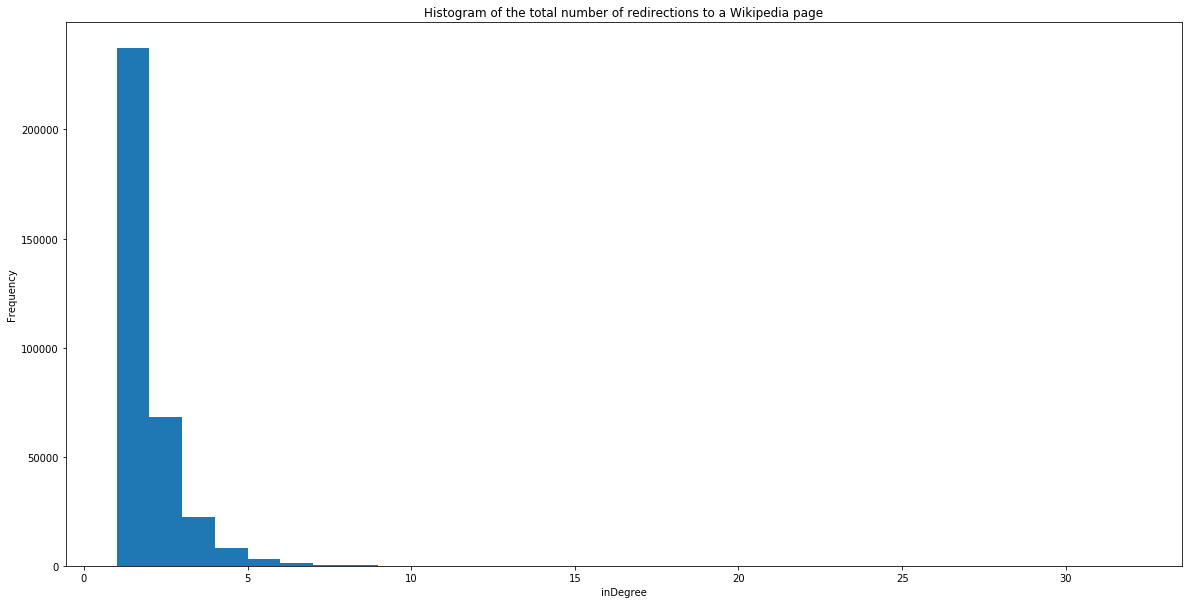

In [11]:
plt.figure(figsize=(20,10))
plt.hist(graph.inDegrees.select("inDegree").rdd.flatMap(lambda x: x).collect(), bins=range(1,33));
plt.ylabel('Frequency')
plt.xlabel('inDegree');
plt.title('Histogram of the total number of redirections to a Wikipedia page')
plt.show()

We observe that the large majority of the nodes in the graph have an in-degree of $1$. This is clarified by the fact that $324.527$ of the $340.906$ nodes in the graph are normal Wiki pages and most of the normal Wiki pages belong only to $1$ (sub)category. Apparently, the above (mathematical) Wiki pages belong to dozens of categories, of which the page [```Principle```](https://en.wikipedia.org/wiki/Principle) does even belong to $32$ categories.

#### 5.3 Degrees in the Wikipedia graph
The last characteristic of the Wiki graph we study is the amount of degrees nodes have. With degree we mean: the total amount of both incoming and outgoing edges of a nodes, i.e. ```inDegree + outDegree```. The top 10 of nodes with the highest degree is:

In [12]:
degree_nodes = graph.degrees.sort("Degree", ascending=False)
degree_nodes.collect()[0:10]

[Row(id='https://en.wikipedia.org/wiki/Category:Language_families', degree=402),
 Row(id='https://en.wikipedia.org/wiki/Category:Telecommunications_by_country', degree=366),
 Row(id='https://en.wikipedia.org/wiki/Category:Art_genres', degree=278),
 Row(id='https://en.wikipedia.org/wiki/Category:Art_movements', degree=268),
 Row(id='https://en.wikipedia.org/wiki/Category:Functional_groups', degree=267),
 Row(id='https://en.wikipedia.org/wiki/Category:Ethnic_groups_in_India', degree=256),
 Row(id='https://en.wikipedia.org/wiki/Category:Deception', degree=252),
 Row(id='https://en.wikipedia.org/wiki/Category:Noble_titles', degree=250),
 Row(id='https://en.wikipedia.org/wiki/Category:Design', degree=249),
 Row(id='https://en.wikipedia.org/wiki/Category:Pseudoscience', degree=247)]

Since the number of ```outDegrees``` is in general much larger than the number of ```inDegrees```, the ```Degrees``` value is largely determined by the number of ```outDegrees```. For this reason, the top 10 of nodes with the highest amount of ```Degrees``` consists solely of categorical Wiki pages and mimics almost completely the top 19 of ```outDegrees```. The distribution over all nodes looks like:

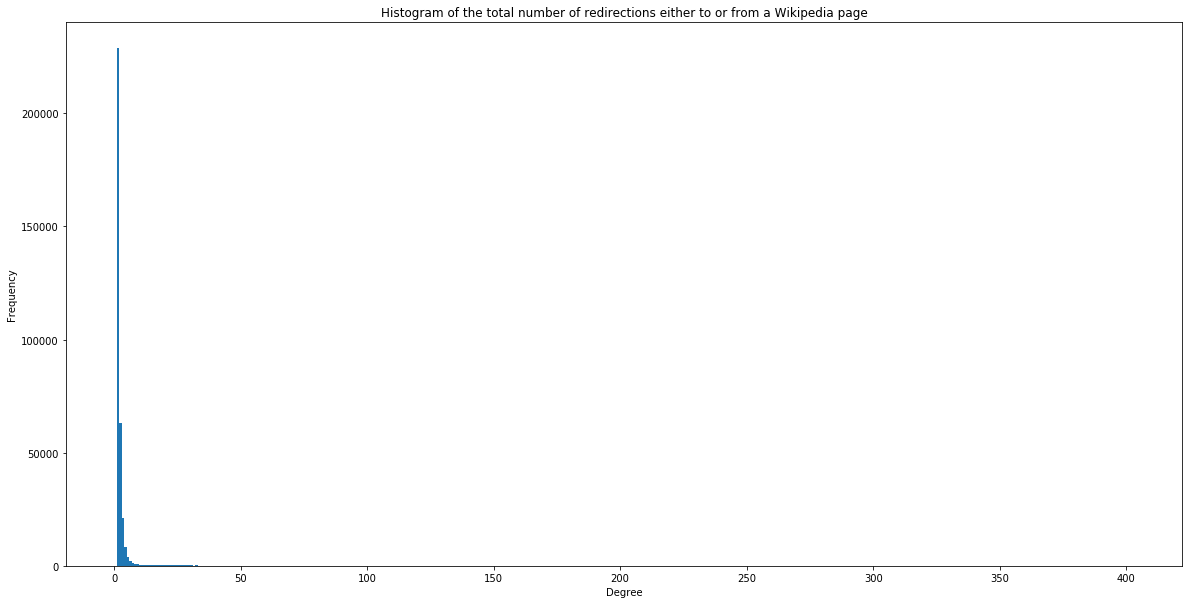

In [13]:
plt.figure(figsize=(20,10))
plt.hist(graph.degrees.select("degree").rdd.flatMap(lambda x: x).collect(), bins=range(1,403));
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Histogram of the total number of redirections either to or from a Wikipedia page')
plt.show()

We see that the vast majority of nodes have a degree 1 to 10, where more than 2/3 of the nodes have a Degree of 1. This observation echoes the view that most of the normal Wiki pages belong only to 1 (sub)category.

In order to answer the main question, in the next section we study the live stream of Wikipedia page modifications. 

### 6. Wikipedia page modification analysis
[This](https://www.pubnub.com/developers/realtime-data-streams/wikipedia-changes/) PubNub channel provides us with all recent modifications of Wikipedia pages. In the final part of this project, we analyse this data stream using PySpark and Graphframes.


#### 6.1 Kafka producer and consumer
We start with creating a Kakfa producer script that sends a ```Hello world!``` message to a Kafka consumer on the GCP virtual machine (VM). Before we can do this, we first need to change some settings on the GCP VM.

1. we move to the ```/usr/lib/kafka``` folder;
2. create a Kafka ```test-topic``` in Zookeeper:
3. edit the ```server.properties``` file in the ```/usr/lib/kafka/config``` folder such that the ```listeners``` and ```advertised.listeners``` listen to the GCP VM on ```st446-w-0.c.sincere-hearth-236110.internal:9092```.

This can be done by the following commands in the GCP shell.

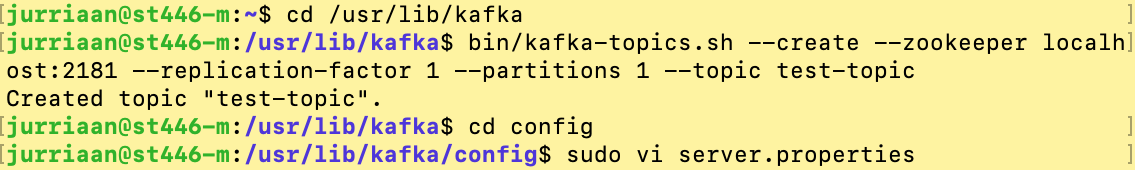

In [8]:
Image(filename = "settings.png")

Now, we create a Kafka producer that can send an arbitrary message to a Kafka consumer.

In [2]:
from kafka import *

topic = 'test-topic'
kafka = KafkaClient('st446-w-0.europe-west2-b.c.sincere-hearth-236110.internal:9092')
producer = SimpleProducer(kafka)

message = "Hello world"
producer.send_messages(topic, message.encode('utf-8'))

[ProduceResponsePayload(topic='topic4', partition=0, error=0, offset=900)]

The message is received by the consumer.

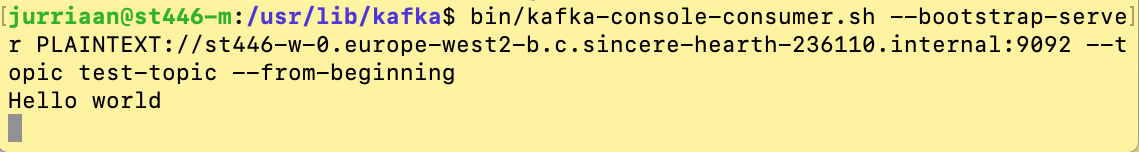

In [9]:
Image(filename = "test_topic_hello_world.png")

So, if we can connect this notebook to the Wiki modification PubNub channel, we can send the data through a Kakfa producer script to a Kafka consumer and to a Spark streaming environment on the GCP VM.

First, we create a new Kafka topic called ```wiki``` and acquire the PubNub subscribe key from the website. Then, with help of the PubNub [Getting started guide](https://www.pubnub.com/docs/getting-started-guides/pubnub-publish-subscribe), we create a call back function to forward the data stream from the Wikipedia channel to the Kafka client.

We forward the following data:

1. the title of the modified Wikipedia item;
2. the link to this item;
3. the user who edited the item. 

This is coded as follows:

In [ ]:
from pubnub import pubnub
from pubnub.callbacks import SubscribeCallback
from pubnub.enums import PNStatusCategory
from pubnub.pnconfiguration import PNConfiguration
from pubnub.pubnub import PubNub
from kafka import *

# kafka configurations
topic = 'wiki'
kafka = KafkaClient('st446-w-0.europe-west2-b.c.sincere-hearth-236110.internal:9092')
producer = SimpleProducer(kafka)

# pubnub configurations
pnconfig = PNConfiguration()
pubnub = PubNub(pnconfig)
pnconfig.subscribe_key = 'sub-c-b0d14910-0601-11e4-b703-02ee2ddab7fe'

# pubnub class
class MySubscribeCallback(SubscribeCallback):
    def presence(self, pubnub, presence):
        pass
    def status(self, pubnub, status):
        pass
    def message(self, pubnub, message):
        # filter data from pubnub channel
        item = message.message['item'].encode('utf-8')
        user = message.message['user'].encode('utf-8')
        link = message.message['link'].encode('utf-8')

        # send messages to Kafka client
        producer.send_messages(topic, b"item: " + item)
        producer.send_messages(topic, b"user: " + user)
        producer.send_messages(topic, b"link: " + link + b"\n")

# connect to pubnub channel
pubnub.add_listener(MySubscribeCallback())
pubnub.subscribe().channels("pubnub-wikipedia").execute()

Our Kafka consumer now looks like this.

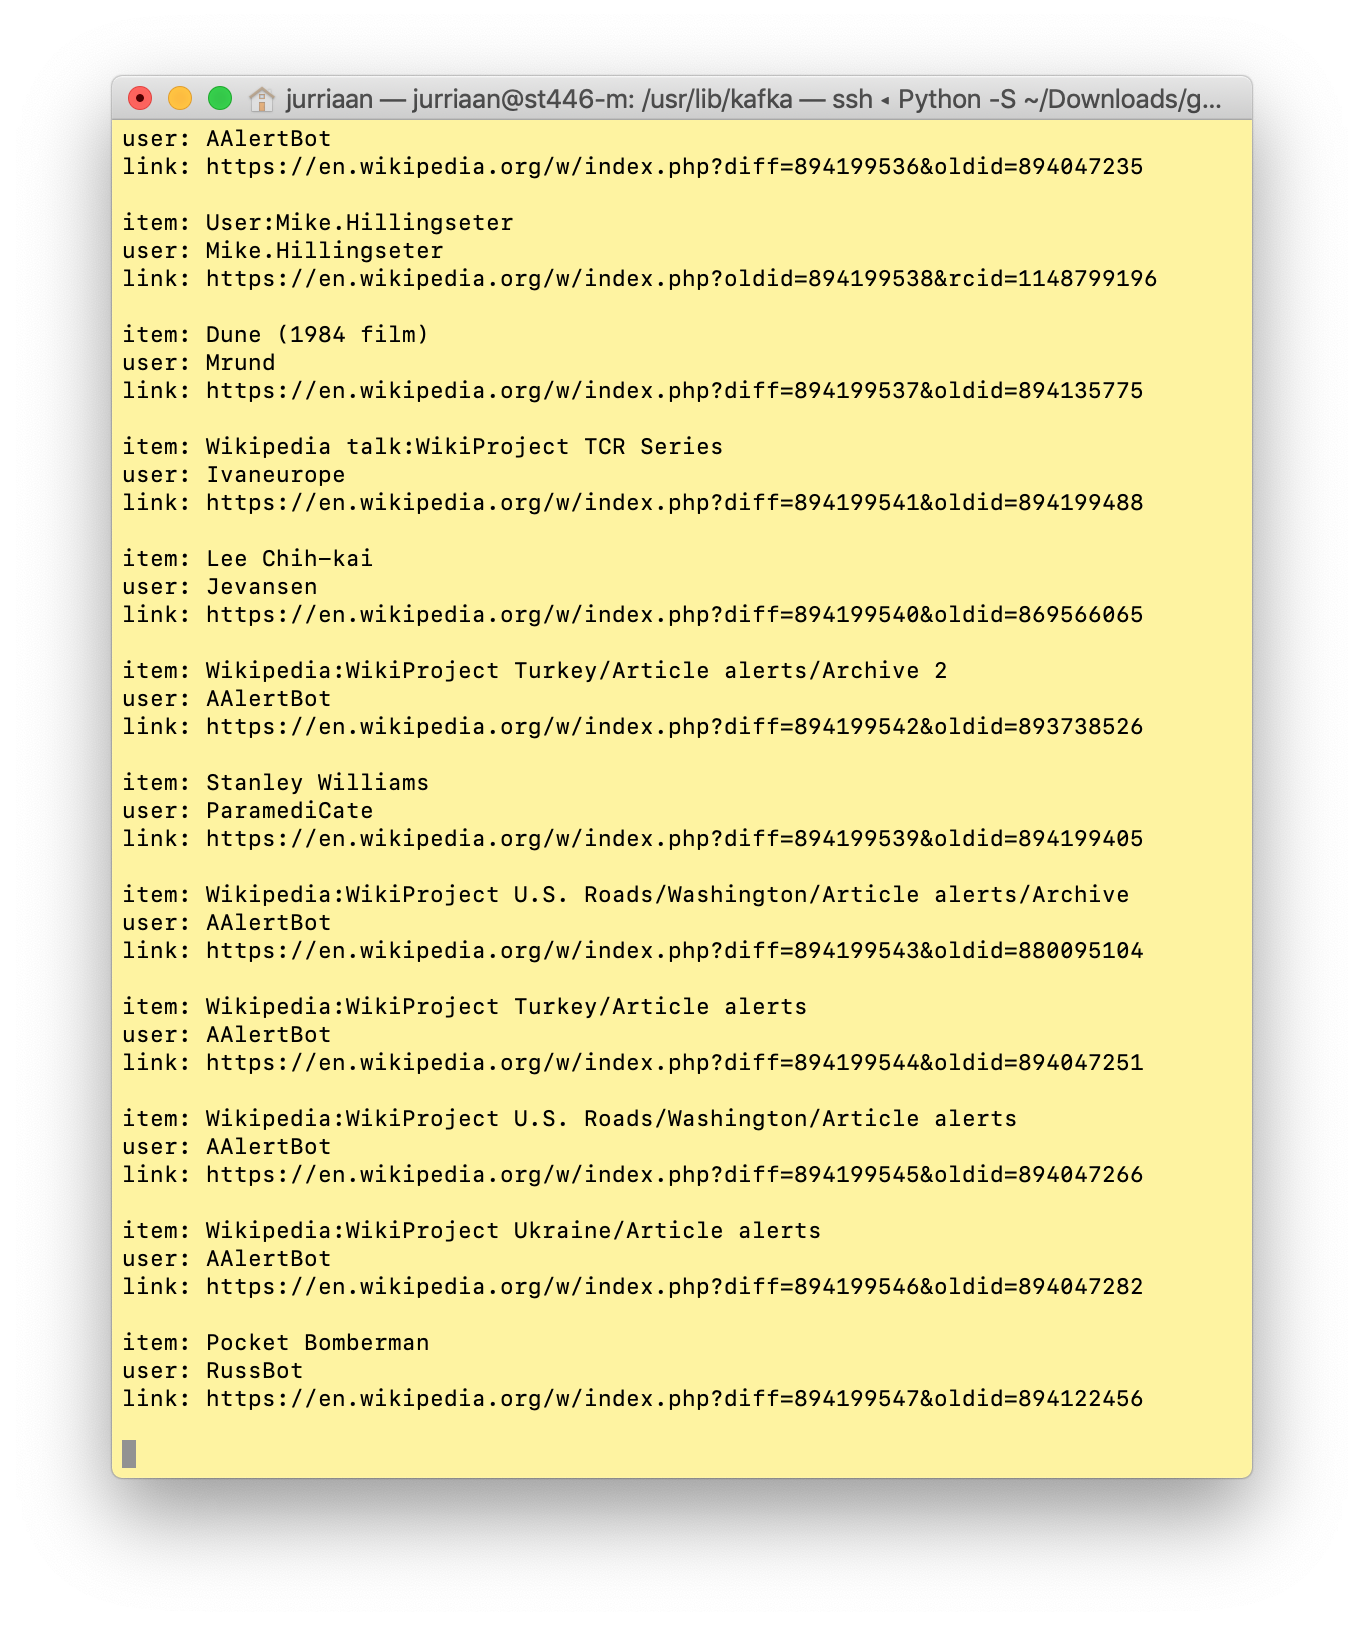

In [5]:
Image(filename = "kafka_consumer_wiki_stream.png")

Which is great! Now, we want to analyse this data stream using the Spark streaming environment. First, we have to change some server properties on the GCP VM.

1. add ```spark.jars.packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.0``` to the end of the ```$SPARK_HOME/conf/spark-defaults.conf``` file;
2. ```unset PYSPARK_DRIVER_PYTHON```.

#### 6.2 Wiki page modifications - added and deleted characters

Then, we create a ```diff_content``` function that webscrapes the link of the given modification page of a Wiki page in the PubNub stream and returns the amount of added and deleted characters on this page. In the mean time, we fixed the package dependencies and got the ```BeautifulSoup``` package start to work on the GCP VM.

In [5]:
from bs4 import BeautifulSoup

def diff_content(url):

    if url[0:10] == 'https://en':
        page = requests.get(url)
        page_content = page.content.decode("utf-8")    
        soup = BeautifulSoup(page_content)
        
        # find original Wiki page url
        url = soup.find_all("div", {"id": "mw-diff-ntitle1"})
        if len(url) != 0:
            if '?' in str(url):
                title_pre = str(url).split('?')[1]
            else:
                title_pre = str(url)

            title_suf = title_pre.split('&')[0]
            title = title_suf.split('=')[1]
            wiki_url = 'https://en.wikipedia.org/wiki/' + title
            
        else:
            wiki_url = 'NA'
        
        # find length of added content
        added = soup.find_all("ins", {"class": "diffchange diffchange-inline"})
        len_add = 0
        for elm in list(added):
            add = str(elm)
            added_split = add.split('>')
            added_content = added_split[1].split('<')[0]
            len_add += len(added_content)
            
        add_print = "+:" + str(len_add)
            
        # find length of deleted content
        delet = soup.find_all("del", {"class": "diffchange diffchange-inline"})
        len_del = 0
        for elm in list(delet):
            delet = str(elm)
            delet_split = delet.split('>')
            delet_content = delet_split[1].split('<')[0]
            len_del += len(delet_content)
        
        del_print = "-:" + str(len_del)

    else:
        wiki_url = 'NA'
        add_print = "-1"
        del_print = "-1"
        

    return(wiki_url, add_print, del_print)

For example, as link ```https://en.wikipedia.org/w/index.php?diff=894203879&oldid=894203075``` is published on the Pubnub channel, the ```diff_content``` function tells us that the modifications were made on the ```Avengers: Endgame``` and that the modification consists of 34 added and 21 deleted characters.

In [6]:
diff_content('https://en.wikipedia.org/w/index.php?diff=894203879&oldid=894203075')

('https://en.wikipedia.org/wiki/Avengers:_Endgame', '+:34', '-:21')

Now, we apply this function to every link published in the Pubnub channel. We edit the above Kafka producer script$^*$ such that the original Wiki page url (not the modification url) and the amount of added and deleted characters are send to the Kafka ```wiki``` topic. 

In order to do this, we only have to change the ```message``` function in the above code. We show the adjusted ```message``` function below.

$^*$ the full script can be found in this Github repository as ```kafka_mod_wiki_stream.py```

In [ ]:
def message(self, pubnub, message):
    link = message.message['link']
    link_mods = diff_content(link).encode('utf-8')

    producer.send_messages(topic, b"link:\n" + link.encode('utf-8') + "mods:", link_mods)

Besides, we create a ```kafka_print.py``` script (this script can be found in this repository too) that is just prints all data that appears in the ```wiki``` topic in a Spark streaming environment. We start the Spark stream with respect to the ```kafka_print.py``` file by:

```bin/spark-submit ~/kafka_print.py localhost:2181 wiki```

The resulting Spark stream in the terminal looks like this:

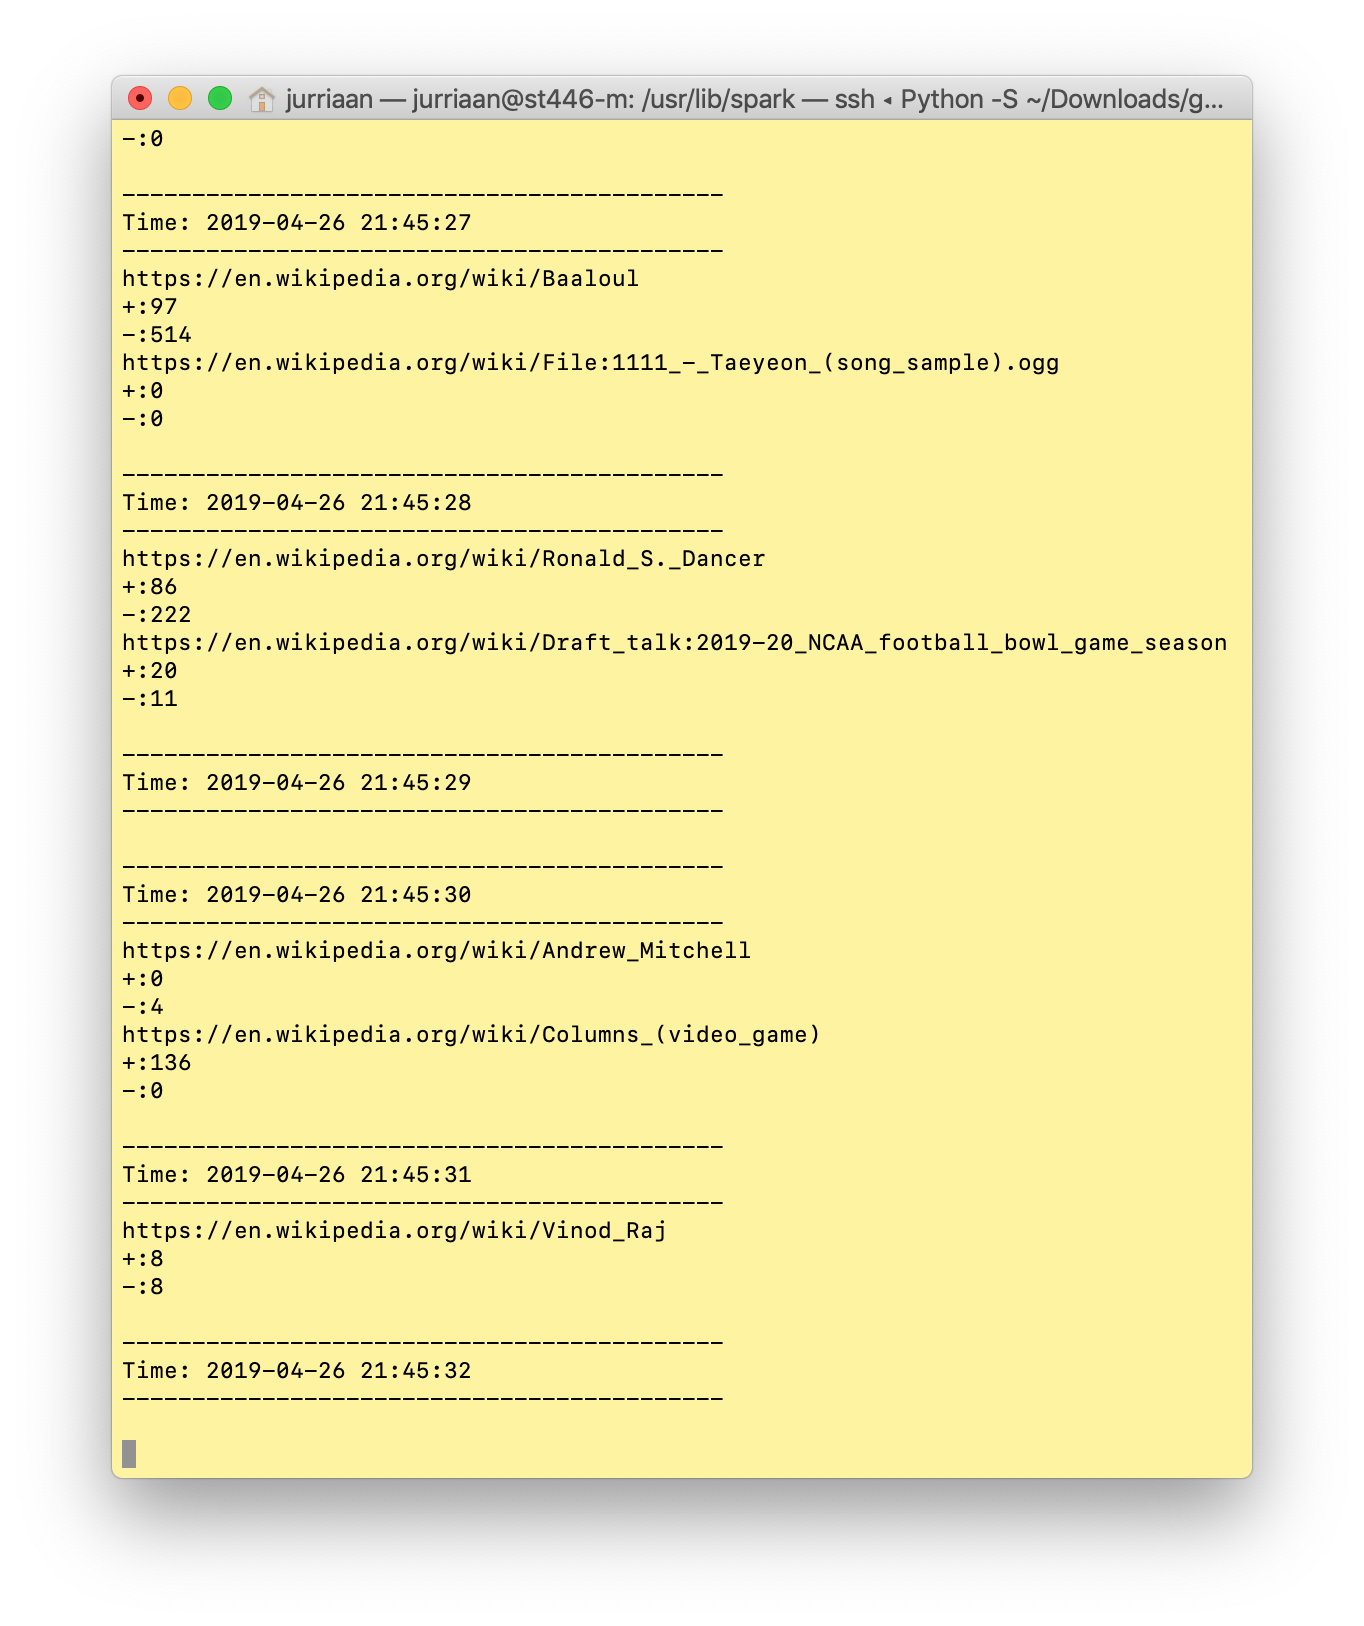

In [7]:
Image(filename = "pubnub_spark_mods.png")

Given this Spark stream, a logical next step would be to create a stateful operation script in Spark that keeps track of the cumulative amount of added and deleted characters on Wikipedia. Unfortunately, I did not succeeded to implement working code in time. 

Instead, we focus on the question to which categories modified Wikipedia pages belong to.

#### 6.3 Wiki page modifications - url dump
Using the above Kafka scripts, we have stored the urls of modified Wikipedia pages for 5 hours. All of these urls were dumped in the ```pubnub_url_dump.csv``` file, which could be found in this repository. We import this .csv file to analyse which of the pages in our graph are modified during those 5 hours.

In [34]:
url_dump = []

with open('pubnub_url_dump.csv', 'r') as f:
    reader = csv.reader(f)
    url_dump = list(reader)

url_dump_ls = url_dump[0]
len(url_dump_ls)

23563

We see that in 5 hours 23.563 Wikipedia pages have been modified. Next, we find which and how much of the 341.023 nodes in our graph were edited. 

In [35]:
intersec_ls = list(set(url_dump_ls) & set(all_unique_nodes_full))
len(intersec_ls)

855

We see that over those 5 hours  855 nodes in our graph were edited. The first one which was edited was:

In [36]:
intersec_ls[0]

'https://en.wikipedia.org/wiki/Freeman_Dyson'

Now, for all of the 855 modified nodes in our graph we want to know to which category they belong. So, we create a function that returns all incoming edges for an arbitrary page url (leaf node) in our graph. Note that all parent nodes of pages are by definition (sub)categories. Hence, the below function returns all (sub)categories a Wikipedia page in our graph belongs to. 

In [37]:
def find_all_edges(url):
    all_edges_ls = []
    
    for edge in edges:
        if edge[1] == url:
            all_edges_ls.append(edge[0])
        else:
            pass
    
    return(all_edges_ls)

For example, the Wiki page about ```Freeman_Dyson``` belongs to 6 different (sub)categories:

In [39]:
dyson_cat = find_all_edges('https://en.wikipedia.org/wiki/Freeman_Dyson')
dyson_cat

['https://en.wikipedia.org/wiki/Category:21st-century_mathematicians',
 'https://en.wikipedia.org/wiki/Category:Freeman_Dyson',
 'https://en.wikipedia.org/wiki/Category:English_mathematicians',
 'https://en.wikipedia.org/wiki/Category:Lorentz_Medal_winners',
 'https://en.wikipedia.org/wiki/Category:Institute_for_Advanced_Study_faculty',
 'https://en.wikipedia.org/wiki/Category:Futurologists']

For each (sub)category we can look up in the dictionary whether it is classified as small, medium or large.

In [40]:
for cat in dyson_cat:
    print(url_dict[cat])

(202, 'large')
(25, 'large')
(206, 'large')
(23, 'medium')
(111, 'large')
(156, 'large')


We repeat this for process for all 588 modified nodes in our graph. 

In [41]:
len_count = 0
subcat_list = []

for elm in intersec_ls:
    parent_cat_ls = find_all_edges(elm)
    subcat_list.append(parent_cat_ls)
    
class_cat_ls = [url_dict[elm][1] for item in subcat_list for elm in item]
len(class_cat_ls)

1470

In total, the 588 modified Wikipedia pages in our graph belong to 1470 (sub)categories. Finally, we ask for the statistics about those category's classification.

In [83]:
from collections import Counter
counter = Counter(class_cat_ls)
counter

Counter({'large': 1116, 'medium': 262, 'small': 92})

Interesting! We see that 76% of all modified pages in our graph are related to a large (sub)category, 18% is related to a medium sized (sub)category and that the remaining 6% belongs to a small category. However, since modified pages in our graph on average belong to exactly 2.5 (sub)categories, we stress that the above statistic does not imply a one-to-one relationship between modification frequency and large, medium or small sized (sub)category yet.

In order to find such a one-to-one relationship, we determine the fraction of nodes that are modified for each category. For all parent (sub)categories of modified Wiki pages, we check whether the (sub)category is classified as small, medium or large. Then, we cumulative sum the total outdegree of this subcategory per size. 

In [78]:
small_count = 0
medium_count = 0
large_count = 0

for item in subcat_list:
    for elm in item:
        categ = url_dict[elm][1]
        if categ == 'small':
            small_count += url_dict[elm][0]
        elif categ == 'medium':
            medium_count += url_dict[elm][0]
        elif categ == 'large':
            large_count += url_dict[elm][0]

This yields that the total outdegree per (sub)categories classification size is:

In [87]:
print("small (sub)categories:", small_count)
print("medium (sub)categories:", medium_count)
print("large (sub)categories:", large_count)

small (sub)categories: 430
medium (sub)categories: 4168
large (sub)categories: 111361


Now, we determine the proportion of modified Wiki page per (sub)category size:

In [86]:
print("small (sub)categories:", counter['small']/small_count)
print("medium (sub)categories", counter['medium']/medium_count)
print("large (sub)categories:", counter['large']/large_count)

small (sub)categories: 0.21395348837209302
medium (sub)categories 0.0628598848368522
large (sub)categories: 0.010021461732563465


Hence, we conclude that Wiki pages that belong to small (sub)categories are modified far more frequent than Wiki pages that belong to medium and large (sub)categories.

With these results we can answer the research quesiton of this project.  

### 7. Conclusion
We conclude that webscraping is an effective method to analyse characteristics of Wikipedia. Thanks to the fixed code strcuture of Wikipedia pages, we were able to build a subset of the graph Wikipedia's categorical reference system represents. Starting at the major category Mathematics, we learnt that within a few steps subcategories are not related anymore to mathematics at all. We gained insight in the ineffectiveness of parallel graph searches without parameter sharing and experienced that plotting high dimensional graphs need a lot of time and memory. Using the fantastic live PubNub Wikipedia modification channel, we observed that on average 78.5 Wikipedia pages are changed per minute and that ```AAlertBot``` is a very active but foolish contributor to the online encyclopedia. Ultimately, we found during our observations that in proportion mainly Wikipedia pages that are related to small (sub)categories were modified.

*To answer the main question: no, Wikipedia pages related to small sized categories are modified more frequently than Wikipedia pages that are related to medium or large sized categories.*

### 8. Discussion
There is no doubt that this project can be improved by devising a real parallel recursive graph search using RDDs. The same holds for keeping track of all added an deleted characters on Wikipedia by using stateful operation in the Spark streaming environment. In addition, the final analysis on modification rates could have been done more efficiently by using Graphframes. On top of that, we could have retrieved more interesting characteristics about the Wikipedia graph by using Graphframes more intensively. Above all, we are pleased with the results and insights we gained during this project.